# Task 1: Rating Prediction via Prompting

## Objective
Design prompts that map Yelp reviews to 1–5 stars with **structured JSON output**, focusing on how prompt design choices affect accuracy, reliability, and JSON validity—without fine-tuning.


## Why Prompt-Only Classification Is Hard

- Reviews mix praise and complaints (3★ vs 4★ is often fuzzy).
- Sarcasm, exaggeration, and late-arriving cues hide the true signal.
- Ratings are ordinal; most errors are off-by-one, not random.
- LLM quirks: hallucinated ratings, broken JSON, over-reliance on tone.
- Practical constraints: cost/latency, single-review calls, and need for deterministic JSON.


## Evaluation Philosophy

Treat prompting like model iteration: design, test, and compare.
We track accuracy, JSON validity, and behavior consistency to see how each prompt changes LLM behavior and trade-offs.


# Dataset & Evaluation Setup

- Dataset: Yelp Reviews (Kaggle). Used ~10k rows for quick EDA; sampled **150 reviews** for prompt evaluation (uniform sample to keep class diversity). Recommendation was ~200; 150 kept for latency/cost.
- Imbalance: 4★/5★ dominate; 1★/2★ underrepresented. Mean rating ≈3.8.
- Metrics: exact accuracy, within ±1 star, MAE, bias, per-class accuracy, JSON validity.
- Inference: single-review requests via OpenRouter, modest delay to avoid rate limits. All runs returned parseable JSON.


## Model Selection

Model: **xiaomi/mimo-v2-flash:free** via OpenRouter.
Rationale: free, open-source, solid instruction following, low latency—good for rapid prompt iteration without fine-tuning.


In [ ]:
from langchain.chat_models import init_chat_model
from os import getenv
from dotenv import load_dotenv

load_dotenv()

# Initialize the model with OpenRouter's base URL
model = init_chat_model(
    model="xiaomi/mimo-v2-flash:free",
    model_provider="openai",
    base_url="https://openrouter.ai/api/v1",
    api_key=getenv("OPENROUTER_API_KEY"),
    temperature=0.1
)

# Prompt 1 — Structured Baseline
- Clear 1–5 star definitions.
- Priority: use explicit rating hints in text before sentiment.
- Return JSON only; brief explanation required.
Goal: observe baseline behavior with minimal rules beyond schema + hints.


In [ ]:
prompt_1 ="""
You are an expert NLP classifier specializing in restaurant and service review sentiment.

### RATING SCALE GUIDELINES:
- 1 Star: Disastrous experience, horrendous service, or major hygiene/quality issues.
- 2 Stars: Subpar. Some potential, but significant failures in food, service, or value.
- 3 Stars: "Okay." Decent but unremarkable, or great food with bad service (balanced).
- 4 Stars: Very good. High quality, with only minor nitpicks (timing, price, small issues).
- 5 Stars: Exceptional. Enthusiastic recommendation with no meaningful negatives.

### CRITICAL INSTRUCTION: RATING HINTS
Users often explicitly state their intended rating or a rating boundary inside the review text.

You MUST:
- Actively search for phrases like:
  - "I give it 3 stars"
  - "rounding down to 2"
  - "would be a 5 if..."
  - "giving an extra star for..."
- If the reviewer explicitly mentions a star rating, prioritize that value over sentiment analysis.
- If half-stars are mentioned (e.g., "3.5 stars"), apply standard rounding and also look at the overall sentiment unless the user specifies a rounding rule.
- Clearly mention in the explanation when a rating hint influenced the final decision.

### TASK:
You will be given {batch_size} reviews. Classify each review according to the rules above.

Return ONLY a valid JSON array in the following format:
[
  {{
    "review_index": <int>,
    "predicted_stars": <int 1-5>,
    "explanation": "<brief reasoning; explicitly state if a rating hint was detected>"
  }}
]"""


## Results (Prompt 1)

| Metric | Value |
| --- | --- |
| Sample size | 150 |
| Exact accuracy | 66.0% |
| Within ±1 star | 97.3% |
| MAE | 0.37 |
| Bias (pred-true) | +0.14 |
| JSON validity | 100% |

**Notes:** Strong on 5★; mild positive bias; mid-range (2★–4★) is hardest. Hints helped when present.


# Prompt 2 — Few-Shot Anchors
- Adds 5 concise examples (1★–5★) to anchor decision boundaries.
- Keeps rating definitions + hint detection from Prompt 1.
Goal: reduce mid-range ambiguity by showing, not just telling.


In [ ]:
prompt_2 = """You are an expert NLP classifier specializing in restaurant and service review sentiment.


### RATING SCALE GUIDELINES:
- 1 Star: Disastrous experience, horrendous service, or major hygiene/quality issues.
- 2 Stars: Subpar. Some potential, but significant failures in food, service, or value.
- 3 Stars: "Okay." Decent but unremarkable, or great food with bad service (balanced).
- 4 Stars: Very good. High quality, with only minor nitpicks (timing, price, small issues).
- 5 Stars: Exceptional. Enthusiastic recommendation with no meaningful negatives.


### CRITICAL INSTRUCTION: RATING HINTS
Users often explicitly state their intended rating or a rating boundary inside the review text.


You MUST:
- Actively search for phrases like:
  - "I give it 3 stars"
  - "rounding down to 2"
  - "would be a 5 if..."
  - "giving an extra star for..."
- If the reviewer explicitly mentions a star rating, prioritize that value over sentiment analysis.
- If half-stars are mentioned (e.g., "3.5 stars"), apply standard rounding and also consider overall sentiment unless the user specifies a rounding rule.
- Clearly mention in the explanation when a rating hint influenced the final decision.


---


### FEW-SHOT EXAMPLES (REFERENCE ONLY)


Example 1:
Review:
"1 star for service, but the food is not ok :( they literally put 4 pieces of chicken on my taco... I will not be going back."


Output:
{
  "predicted_stars": 1,
  "explanation": "Reviewer explicitly states '1 star for service' and describes repeated poor food quality, indicating a disastrous experience."
}


---


Example 2:
Review:
"Ahh man, I REALLY wanted this to be good... Better than Pizza Hut, but for all the fuss and flash, you expect a lot more."


Output:
{
  "predicted_stars": 2,
  "explanation": "Multiple complaints about food quality and value with limited positives suggest a subpar experience, aligning with a 2-star rating."
}


---


Example 3:
Review:
"This really is more of a lady's hardware store... they had something HD didn't, and at a good price."


Output:
{
  "predicted_stars": 3,
  "explanation": "Balanced and neutral tone with mild praise but no strong enthusiasm reflects an average experience."
}


---


Example 4:
Review:
"I had a chicken panini and it was more than enough... people are very friendly... nice place."


Output:
{
  "predicted_stars": 4,
  "explanation": "Strongly positive experience with good food and friendly service, with no major negatives mentioned."
}


---


Example 5:
Review:
"TJ was there for me when my water heater broke... very grateful, and I will continue referring!"


Output:
{
  "predicted_stars": 5,
  "explanation": "Highly enthusiastic praise and intent to recommend indicate an exceptional experience."
}


---


### TASK:
You will be given {batch_size} new reviews.


Classify EACH review according to the rules above.


Return ONLY a valid JSON array in the following format:
[
  {
    "review_index": <int>,
    "predicted_stars": <int 1-5>,
    "explanation": "<brief reasoning; explicitly state if a rating hint was detected>"
  }
]


### REVIEWS TO CLASSIFY:
{input}

"""

## Results (Prompt 2)

| Metric | Value |
| --- | --- |
| Sample size | 150 |
| Exact accuracy | 66.7% |
| Within ±1 star | 98.7% |
| MAE | 0.35 |
| Bias (pred-true) | +0.09 |
| JSON validity | 100% |

**Notes:** Few-shot examples slightly improve accuracy and reduce bias. Mid-range still noisy; prompt length increases tokens.


# Prompt 3 — Heuristic Reasoning
- Forces an analysis protocol (hints → segment food/service/value → weigh positives/negatives → heuristics).
- Removes examples; relies on rules and rational framing.
Goal: improve consistency on mixed reviews via explicit steps.


In [ ]:
prompt_3 = """You are an expert Review Analyzer acting as a rational reasoning engine.

### OBJECTIVE:
Analyze the customer review to determine the exact 1-5 star rating.

### ANALYSIS PROTOCOL (MENTAL STEPS):
Before assigning a rating, you must perform the following analysis internally:
1. Identify Explicit Hints (e.g., "I'd give it a 4").
2. Segment the Experience: Food, Service, Value, Atmosphere.
3. Weigh the Sentiment: Are negatives deal-breakers or minor nitpicks?
4. Calculate the Balance using heuristic rules.

### RATING DEFINITIONS:
- 1 Star: Unacceptable. Anger, regret, warning others away.
- 2 Stars: Disappointing. More negatives than positives.
- 3 Stars: Average. Mixed or neutral experience.
- 4 Stars: Great. Enjoyable with small flaws.
- 5 Stars: Flawless or ecstatic.

### OUTPUT FORMAT:
Return ONLY a valid JSON array of objects.

[
  {
    "review_index": <int>,
    "predicted_stars": <int 1-5>,
    "explanation": "<reasoning>"
  }
]

### REVIEWS TO CLASSIFY:
{input}"""

## Results (Prompt 3)

| Metric | Value |
| --- | --- |
| Sample size | 150 |
| Exact accuracy | 64.7% |
| Within ±1 star | 98.7% |
| MAE | 0.37 |
| Bias (pred-true) | +0.14 |
| JSON validity | 100% |

**Notes:** More explainable outputs, but accuracy slipped—rules constrained nuance, especially 2★–3★.


# Prompt 4 — Conservative Rule-Gated
- Defaults to 3★ unless strong evidence otherwise; explicit overrides for safety issues.
- Requires enthusiasm + recommendation for 5★; chooses lower rating on uncertainty.
Goal: maximize reliability/guardrails, even if slightly less accurate.


In [ ]:
prompt_4 ='''You are an expert review rating classifier optimized for accuracy and conservatism.

Your task is to assign a 1–5 star rating to each review.
Follow the rules strictly and in order.

---

### STEP 1: EXPLICIT RATING OVERRIDE (HIGHEST PRIORITY)

If the review explicitly mentions a star rating or score:
- Examples: 3 stars, 4/5, would be a 5 if, rounding down to 2
→ Use that rating directly.

---

### STEP 2: INFORMATION SUFFICIENCY CHECK (CRITICAL)

Before interpreting sentiment, determine whether the review describes a real experience.

If the review is:
- Extremely short
- Brand-only
- Vague praise or complaint without details

→ DEFAULT TO 3 STARS

Do not assign 1 or 5 stars without sufficient detail.

---

### STEP 3: NEGATIVE SEVERITY CHECK

If the review mentions:
- Hygiene, safety, or health issues → MAX 1 STAR
- Rude staff, scams, repeated failure, or strong warnings → MAX 2 STARS

These limits override positive language.

---

### STEP 4: POSITIVE INTENSITY AND ENDORSEMENT CHECK

To assign 5 STARS, the review must show:
- Strong enthusiasm
- Clear recommendation or intent to return

If positives are strong but:
- No explicit recommendation exists
- Minor complaints are present

→ Assign 4 STARS

---

### STEP 5: DEFAULT BALANCE RULE

If the review:
- Contains mixed positives and negatives
- Feels neutral or average
- Lacks strong emotional signals

→ Assign 3 STARS

When uncertain between two ratings, choose the lower one.

---

### OUTPUT FORMAT (STRICT)

Return ONLY a valid JSON array.

Rules for output:
- No step numbers
- No quotation marks inside explanations
- Explanation must be under 15 words
- Use plain language

Format:
[
  {
    "review_index": <int>,
    "predicted_stars": <int 1-5>,
    "explanation": "<short justification>"
  }
]

---

### REVIEWS TO CLASSIFY:
{input}

'''

## Results (Prompt 4)

| Metric | Value |
| --- | --- |
| Sample size | 150 |
| Exact accuracy | 63.3% |
| Within ±1 star | 98.7% |
| MAE | 0.38 |
| Bias (pred-true) | +0.23 |
| JSON validity | 100% |

**Notes:** Safest behavior (no bad JSON, stable for short/implicit reviews) but over-conservative—downgrades some genuine 4★/5★ cases.


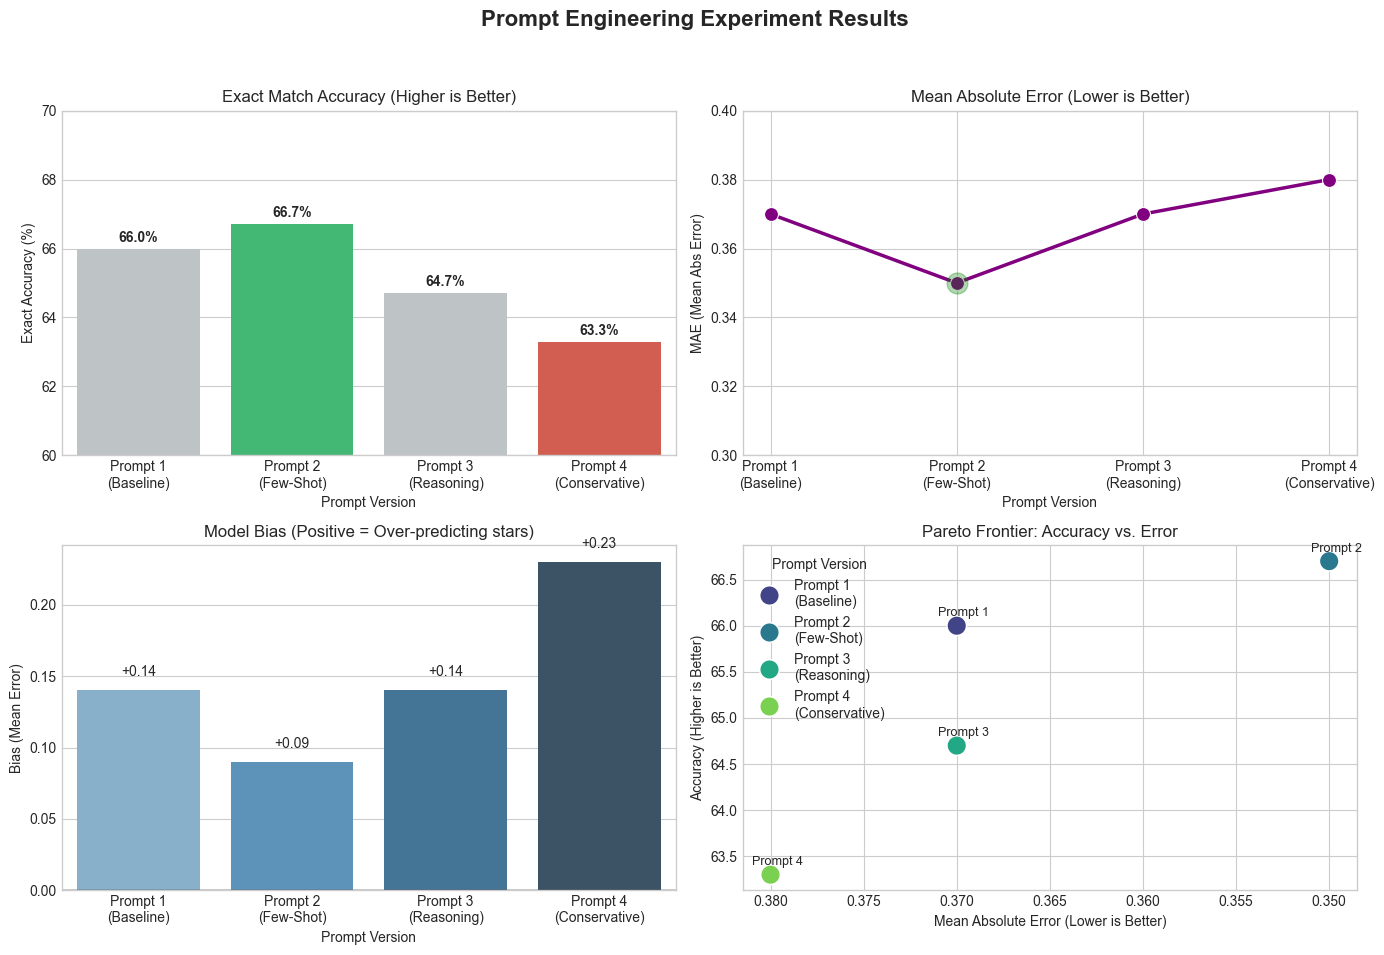

# Final Comparison & Takeaways

## Performance Ceiling
Prompt-only approaches plateau around **66–67% exact accuracy** (~99% within ±1 star). Mid-range ambiguity (2★–4★) is the main limiter; 5★ remains easy.

## Comparison
| Prompt | Strategy | Exact | MAE | Bias | JSON OK |
| --- | --- | --- | --- | --- | --- |
| 1 | Structured + hints | 66.0% | 0.37 | +0.14 | 100% |
| 2 | Few-shot anchors | **66.7%** | **0.35** | **+0.09** | 100% |
| 3 | Heuristic reasoning | 64.7% | 0.37 | +0.14 | 100% |
| 4 | Conservative rules | 63.3% | 0.38 | +0.23 | 100% |

## What Worked
- Explicit rating-hint detection boosted correctness when hints existed.
- Few-shot examples (Prompt 2) gave the best accuracy and lowest bias.
- Guardrails in Prompt 4 improved stability for vague/short reviews.

## Trade-offs
- More rules ≠ better accuracy; over-constraining hurts nuance.
- Conservative defaults reduce false praise but lower recall on strong positives.
- Token cost rises with examples; keep prompts lean for production.

## Recommended Use
- Default: Prompt 2 for best balance of accuracy and cost.
- Safety fallback: Prompt 4 when inputs are short, vague, or high-stakes.
- Future work: small fine-tune or RAG-powered few-shot to break the ~67% ceiling.
## Observed Model Behavior Patterns

### 1. Bias Toward Higher Ratings
The model consistently showed a slight **positive bias**, especially for:
- Long reviews with mostly positive language
- Reviews containing mild complaints but strong praise

This aligns with the dataset’s natural skew toward 4★ and 5★.



### 2. Mid-Star Ambiguity (3★–4★)
The hardest cases involved:
- Balanced pros and cons
- Reviews where the final sentiment contradicted the tone
- “Good but not great” language

These errors were usually **off by one star**, not catastrophic failures.



### 3. Explicit Rating Mentions Matter
Prompts that explicitly instructed the model to **extract stated ratings** showed:
- Higher correctness
- Lower variance
- Better alignment with ground truth

This was one of the most impactful prompt improvements.



### 4. Structured Output Is a First-Class Concern
Even when predictions were reasonable, **invalid JSON would break downstream systems**.

Explicit schema enforcement dramatically improved:
- Parse success
- Pipeline stability
- Deployment readiness



## Shortcomings & Limitations

Despite strong performance, several limitations remain:

- No fine-tuning or task-specific learning
- No cross-domain evaluation (e.g., product or movie reviews)
- Small evaluation sample due to rate limits
- No multi-pass reasoning or self-consistency checks
- Single-model inference (no ensemble behavior)

These are inherent trade-offs of a **prompt-only, zero-shot approach**.



## What Could Be Improved Further

If given more time or resources, the following improvements would be explored:

1. **Self-consistency decoding**  
   Run the same prompt multiple times and aggregate predictions.

2. **Two-stage prompting**  
   - Stage 1: Extract explicit rating hints
   - Stage 2: Decide final rating using strict rules

3. **Domain-adaptive rating definitions**  
   Slightly different rating scales for:
   - Restaurants
   - Services
   - Products

4. **Hybrid systems**  
   Combine:
   - Lightweight classifier for coarse prediction
   - LLM for explanation and correction



## Final Recommendation

For production usage:
- **Prompt 4** is preferred due to its **determinism, structured output, and reliability**
- **Prompt 3** is ideal when interpretability and nuanced reasoning are prioritized

Overall, this task demonstrates that **prompt engineering is an iterative engineering discipline**, not a one-shot exercise, and that careful evaluation can significantly improve LLM system behavior even without model fine-tuning.
